In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

## I. Introduction to Data

### 1. Order Book

Order book is an electronic list of buy and sell orders for a specific financial instruments organized by preice level. The order book data is a continuous represtation of market demand/supply and therefore it is considered as the top data source for market research.   

The table shown below is a snapshot of an order book of a stock. The **bid** column contains all intended buy orders, while the **ask** column contains all intended sell orders.

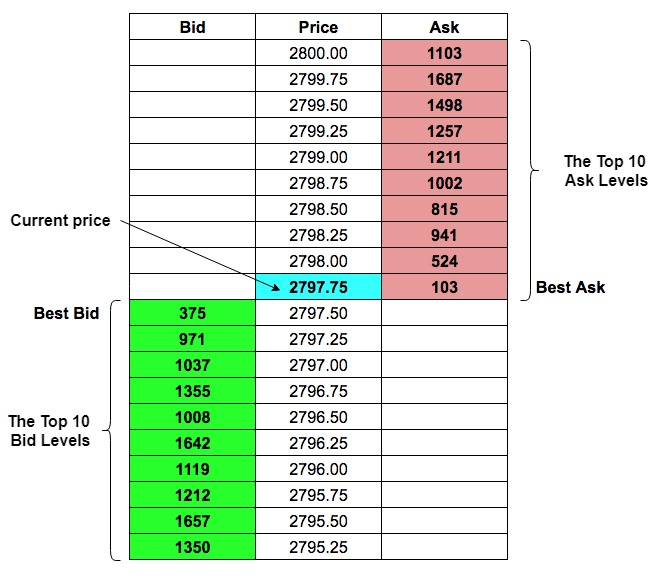

In [3]:
from IPython.display import Image
Image('/Users/zjy/Desktop/orderbook.PNG')

### 2. Requested Submission Template

In [4]:
sample_submission = pd.read_csv('/Users/zjy/Downloads/ML Project Data/sample_submission.csv')
sample_submission.head()

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


This is the template we should follow when we submit our final result.

### 3. Training Data

In [5]:
train = pd.read_csv('/users/zjy/Downloads/ML Project Data/train.csv')
print("training data shape:", train.shape)
train.head()

training data shape: (428932, 3)


,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


**stock_id**: ID of the stock

**time_id**: ID of the time bucket

**target**: realized volatility of the next 10-minute window under the same stock_id and time_id

In [6]:
train.groupby(['stock_id']).size()

stock_id
0      3830
1      3830
2      3830
3      3830
4      3830
       ... 
122    3830
123    3830
124    3830
125    3830
126    3830
Length: 112, dtype: int64

In [7]:
train.groupby(['time_id']).size()

time_id
5        112
11       112
16       112
31       112
62       112
        ... 
32751    112
32753    112
32758    112
32763    112
32767    112
Length: 3830, dtype: int64

In [8]:
for col in train.columns:
    print(col + ": " + str(len(train[col].unique())))

stock_id: 112
time_id: 3830
target: 414287


There are 112 stocks with 3830 different time_id and 414287 different target.

### 4. Testing Data

In [9]:
test = pd.read_csv('/users/zjy/Downloads/ML Project Data/test.csv')
print("testing data shape:", train.shape)
test.head()

testing data shape: (428932, 3)


,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


We find that **row_id = stock_id + '-' + time_id**

## II. Exploratory Data Analysis

### 1. Target (Realized Volatility)

Mean:  0.0039
Median:  0.0030
Skew:  2.8226
Kurtosis:  14.9611


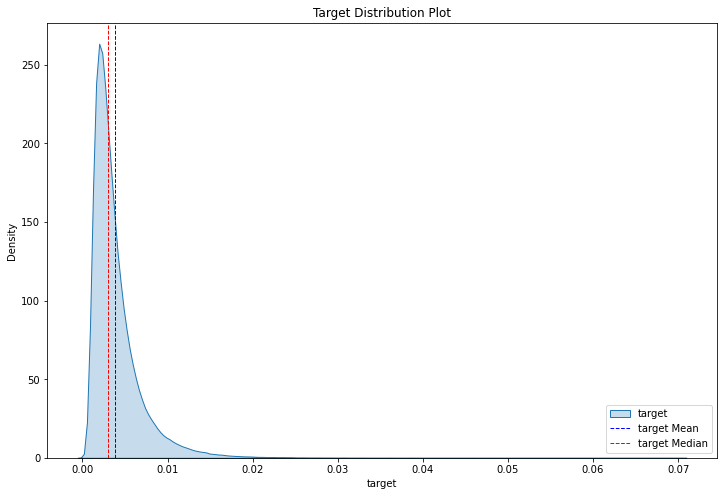

In [35]:
def visualization(target):
    print(f'Mean: {train[target].mean(): .4f}')
    print(f'Median: {train[target].median(): .4f}')
    print(f'Skew: {train[target].skew(): .4f}')
    print(f'Kurtosis: {train[target].kurtosis(): .4f}')

    plt.figure(figsize=(12, 8))
    sns.kdeplot(data=train[target], label=target, fill=True)
    plt.axvline(train[target].mean(), label=f'{target} Mean', color='b', linewidth=1, linestyle='--')
    plt.axvline(train[target].median(), label=f'{target} Median', color='r', linewidth=1, linestyle='--')
    plt.legend(loc=4, fontsize=10)
    plt.title('Target Distribution Plot')
    plt.show()
visualization('target')

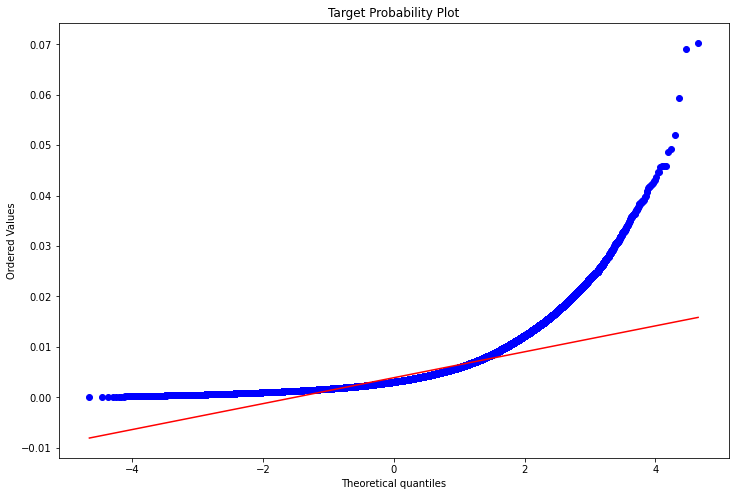

In [33]:
plt.figure(figsize=(12, 8))
probplot(train['target'], plot=plt)
plt.title('Target Probability Plot')
plt.show()

Red line stands for Normal Distribution.
Blue line stands for the sample data.
The probability plot shows that the distribution of target is far from Normal Distribution.

In [19]:
target_means = train.groupby('stock_id')['target'].mean()
target_stds = train.groupby('stock_id')['target'].std()

target_means_stds = pd.concat([target_means, target_stds], axis=1)
target_means_stds.columns = ['mean', 'volatility']
target_means_stds.sort_values(by='mean', ascending=True, inplace=True)

target_means_stds


,mean,volatility
stock_id,,
43,0.001475,0.001227
29,0.001836,0.001232
46,0.001941,0.001455
125,0.002016,0.001703
41,0.002109,0.001613
...,...,...
27,0.006738,0.004435
75,0.006907,0.003982
6,0.006923,0.003323


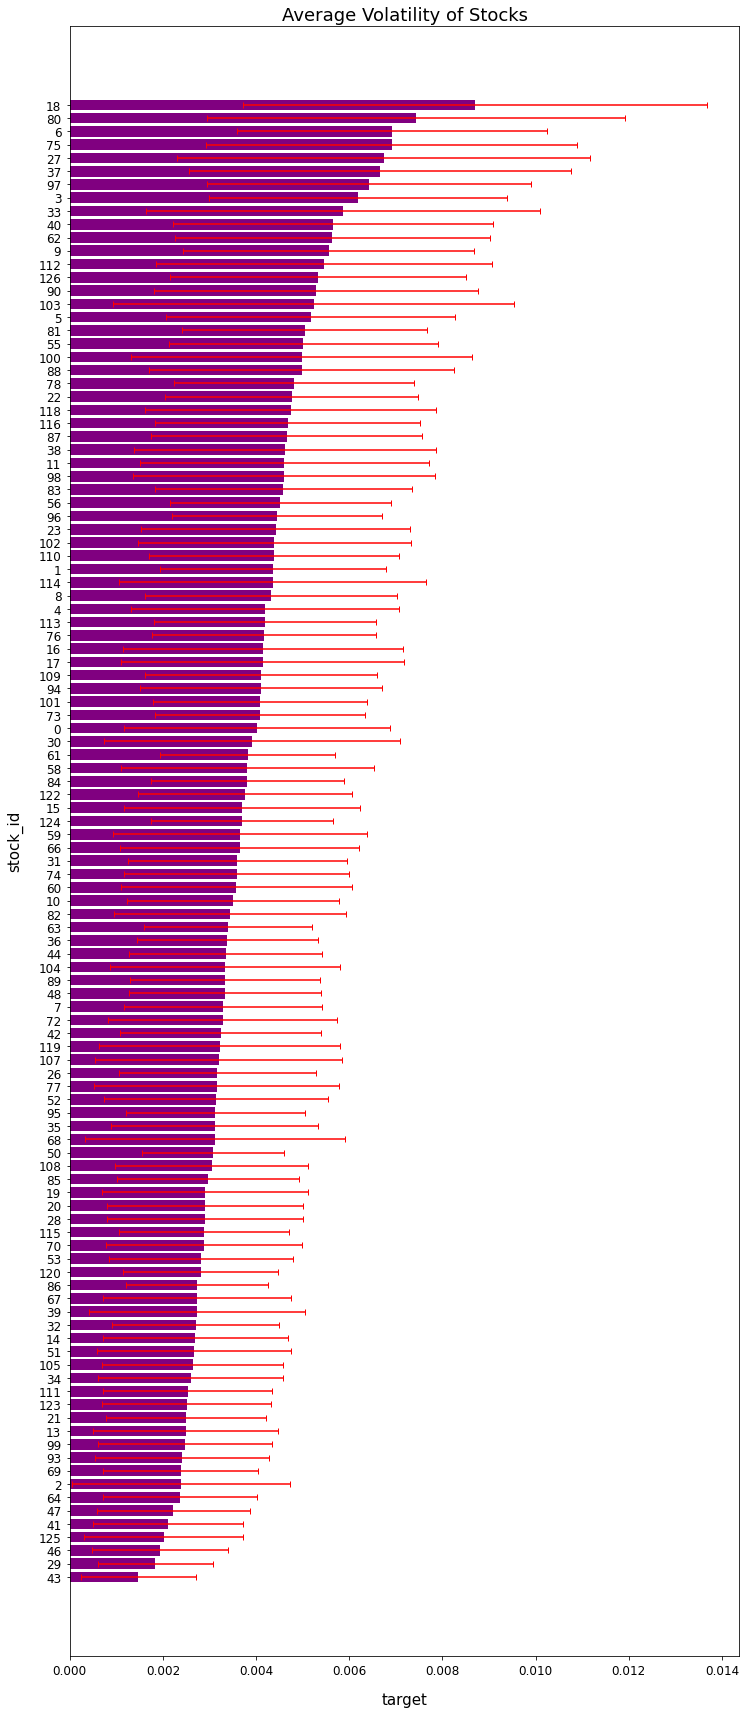

In [20]:
fig, ax = plt.subplots(figsize=(12, 30))
ax.barh(
    y=np.arange(len(target_means_stds)),
    color='purple',
    width=target_means_stds['mean'],
    xerr=target_means_stds['volatility'],
    ecolor='red',
    fill=True,
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_stds)))
ax.set_yticklabels(target_means_stds.index)
ax.set_xlabel('target', size=15, labelpad=15)
ax.set_ylabel('stock_id', size=15, labelpad=15)
ax.tick_params(axis='x', labelsize=12, pad=5)
ax.tick_params(axis='y', labelsize=12, pad=5)
ax.set_title("Average Volatility of Stocks", size=18, pad=5)
plt.show()

Stocks are ranked by their mean volatilities, from most volatile to least volatile.

### 2. Time_id Distribution

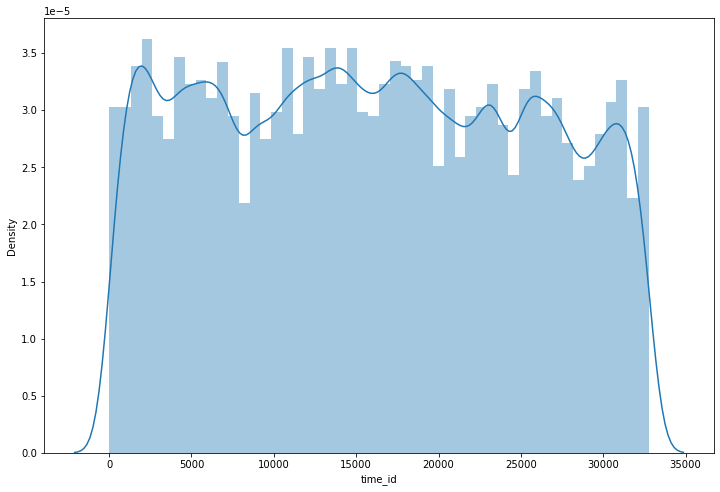

In [31]:
plt.figure(figsize=(12, 8))
sns.distplot(train['time_id'])
plt.show()

### 3. Target - Time_id Relationship

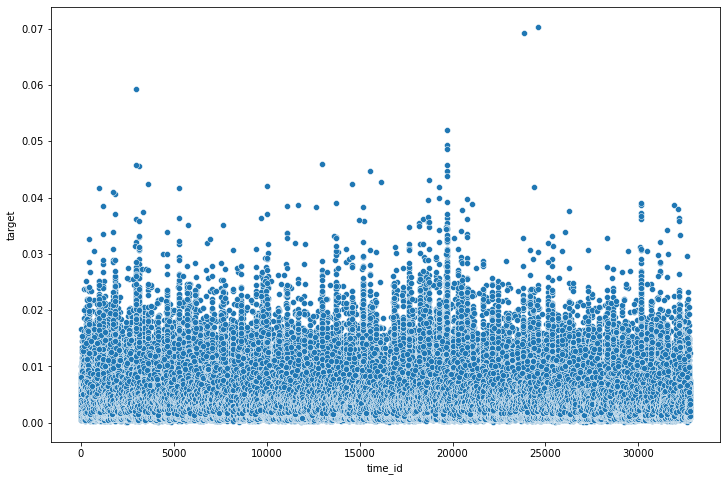

In [32]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x="time_id", y="target")
plt.show()

From the scatterplot we can see more clearly that there are some extreme outliers of the realized volatility.

### 4. Difference between BOOK parquet & TRADE parquet

In the real market, not all Bis/Ask orders can be successfully transactioned, which depends on whether the Bid price meets the Ask price or not. So the **trade parquet** is expected to be **more sparse than** the **book parquet** (order book).

In [23]:
# book_train.parquet - all stocks & all times
book = pd.read_parquet("/users/zjy/Downloads/ML Project Data/book_train.parquet")
print("book parquet shape:", book.shape)
pd.concat([book.head(), book.tail()])

book parquet shape: (167253289, 11)


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
167253284,32767,589,0.999662,0.999797,0.999527,0.999932,400,600,400,528,99
167253285,32767,590,0.999662,0.999797,0.999527,0.999932,400,500,400,528,99
167253286,32767,592,0.999527,0.999797,0.999391,0.999932,900,600,600,528,99
167253287,32767,596,0.999527,0.999797,0.999391,0.999932,900,700,600,628,99
167253288,32767,597,0.999527,0.999797,0.999391,0.999932,600,700,600,628,99


**seconds_in_bucket**: Number of seconds from the start of the bucket, always starting from 0.

**bid_price[1/2]**: Normalized prices of the most/second most competitive buy level.

**ask_price[1/2]**: Normalized prices of the most/second most competitive sell level.

**bid_size[1/2]**: The number of shares on the most/second most competitive buy level.

**ask_size[1/2]**: The number of shares on the most/second most competitive sell level.

In [24]:
# trade_train.parquet - all stocks & all times
trade =  pd.read_parquet("/users/zjy/Downloads/ML Project Data/trade_train.parquet")
print("trade parquet shape:", trade.shape)
pd.concat([trade.head(), trade.tail()])

trade parquet shape: (38382741, 6)


,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0
38382736,32767,570,0.999932,100,1,99
38382737,32767,575,0.999932,100,1,99
38382738,32767,579,0.999797,300,3,99
38382739,32767,584,0.999854,172,2,99
38382740,32767,592,0.999662,400,5,99


**price**: The average price of executed transactions happening in one second.

**size**: The sum number of shares traded.

**order_count**: The number of unique trade orders taking place.

### 5. Exploration under a particular stock_id & time_id

In [25]:
stock_id = '1'
time_id = 5

book_study = pd.read_parquet(f"/users/zjy/Downloads/ML Project Data/book_train.parquet/stock_id={stock_id}")
book_study = book_study[book_study['time_id']==time_id]
book_study.loc[:,'stock_id'] = stock_id

trade_study = pd.read_parquet(f"/users/zjy/Downloads/ML Project Data/trade_train.parquet/stock_id={stock_id}")
trade_study = trade_study[trade_study['time_id']==time_id]
trade_study.loc[:, 'stock_id'] = stock_id

**5.1 Book (train) Parquet**

In [26]:
book_study.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100,1
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,1
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,1
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,1
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,1


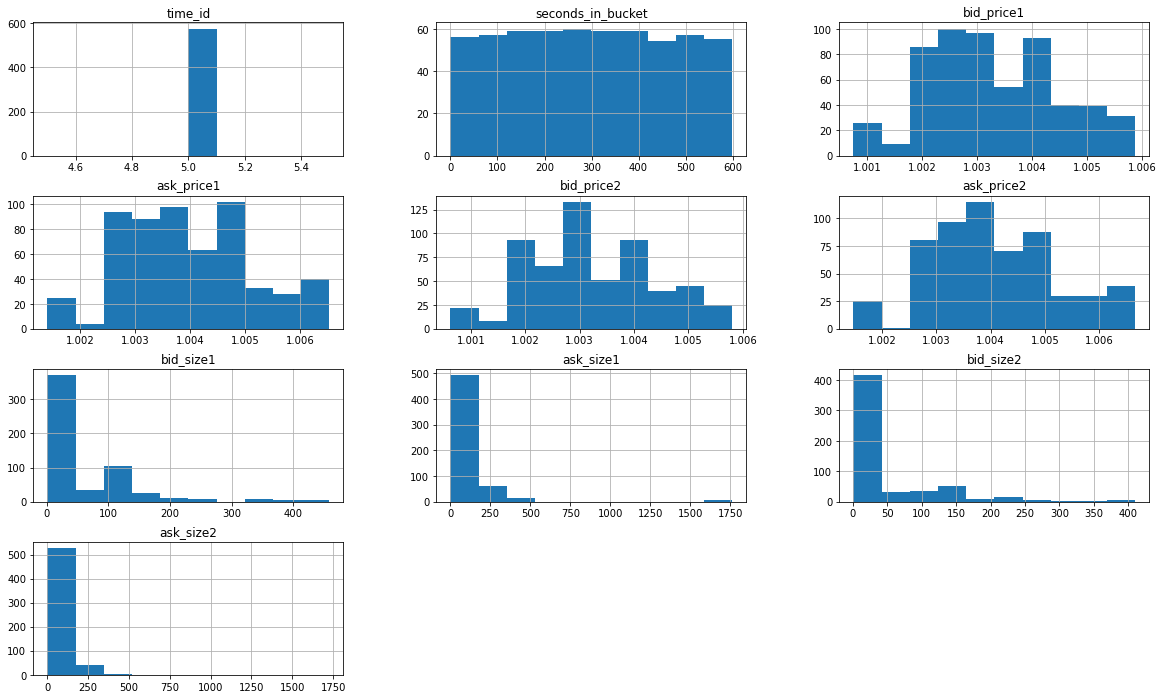

In [27]:
book_study.hist(figsize=(20,12))
plt.show()

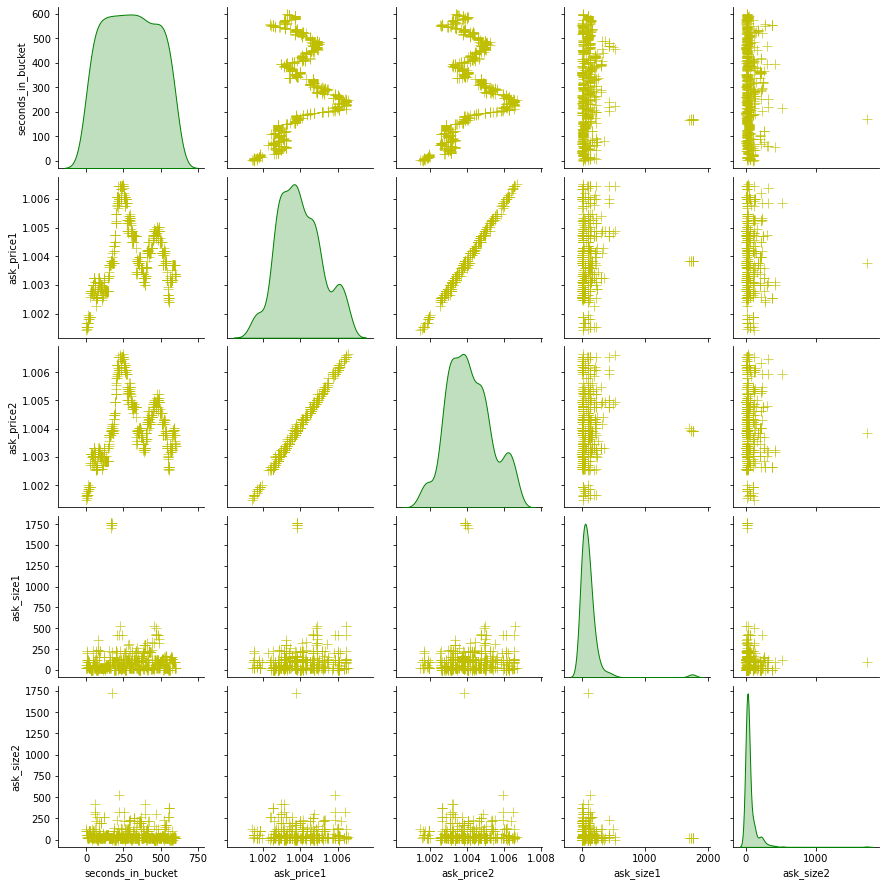

In [28]:
sns.pairplot(
    book_study[['seconds_in_bucket','ask_price1','ask_price2','ask_size1','ask_size2']], 
    kind='scatter', 
    diag_kind='kde', 
    diag_kws=dict(shade=True, color='g'),
    plot_kws=dict(s=100, color='y', alpha=0.8),
    markers="+",
    height=2.5
    )
plt.show()

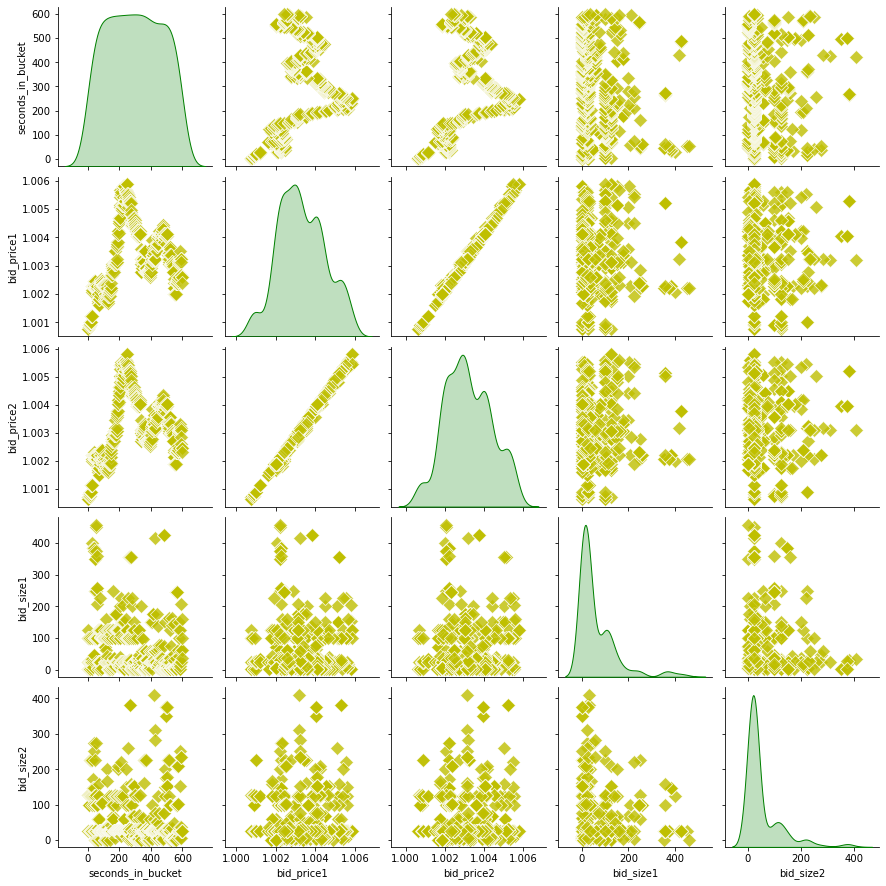

In [29]:
sns.pairplot(
    book_study[['seconds_in_bucket','bid_price1','bid_price2','bid_size1','bid_size2']],
    kind='scatter', 
    diag_kind='kde', 
    diag_kws=dict(shade=True, color='g'),
    plot_kws=dict(s=100, color='y', alpha=0.8),
    markers="D",
    height=2.5
)
plt.show()

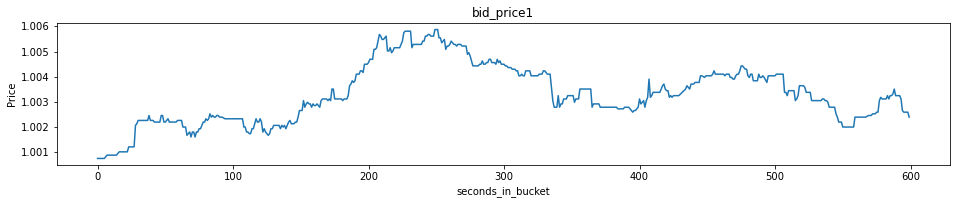

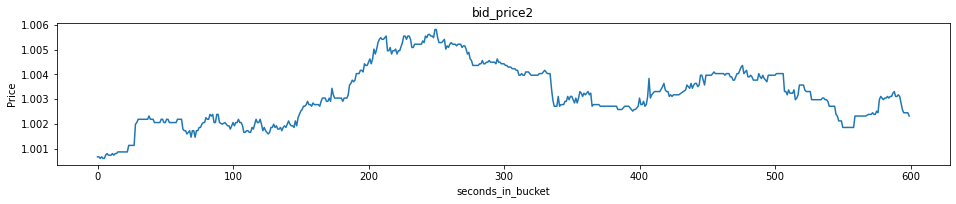

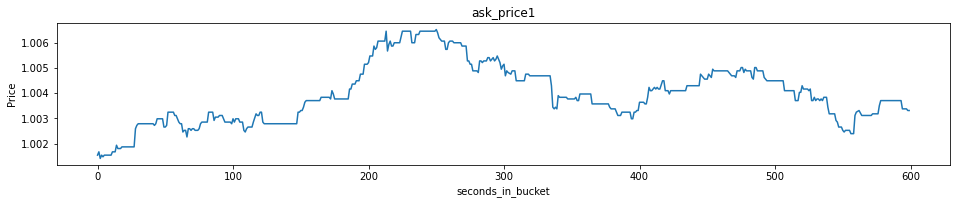

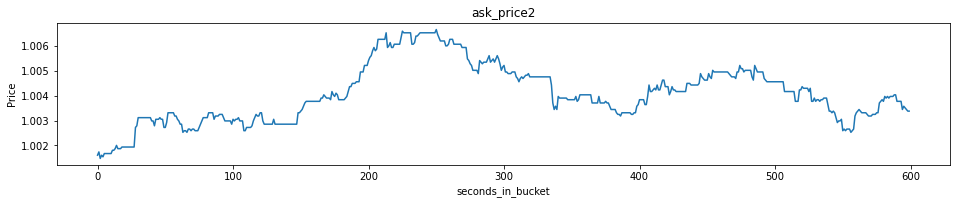

In [30]:
select_price = ['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2']

for num, name in enumerate(select_price):
    plt.figure(figsize=(16, 12))
    plt.subplot(4, 1, num + 1)
    plt.plot(book_study['seconds_in_bucket'], book_study[name])
    plt.xlabel('seconds_in_bucket')
    plt.ylabel('Price')
    plt.title(name)
plt.show()

**5.2 Trade (train) Parquet**

In [39]:
trade_study.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,28,1.002080,553,11,1
1,5,39,1.002460,8,3,1
2,5,42,1.002308,147,4,1
3,5,44,1.002788,1,1,1
4,5,51,1.002657,100,2,1


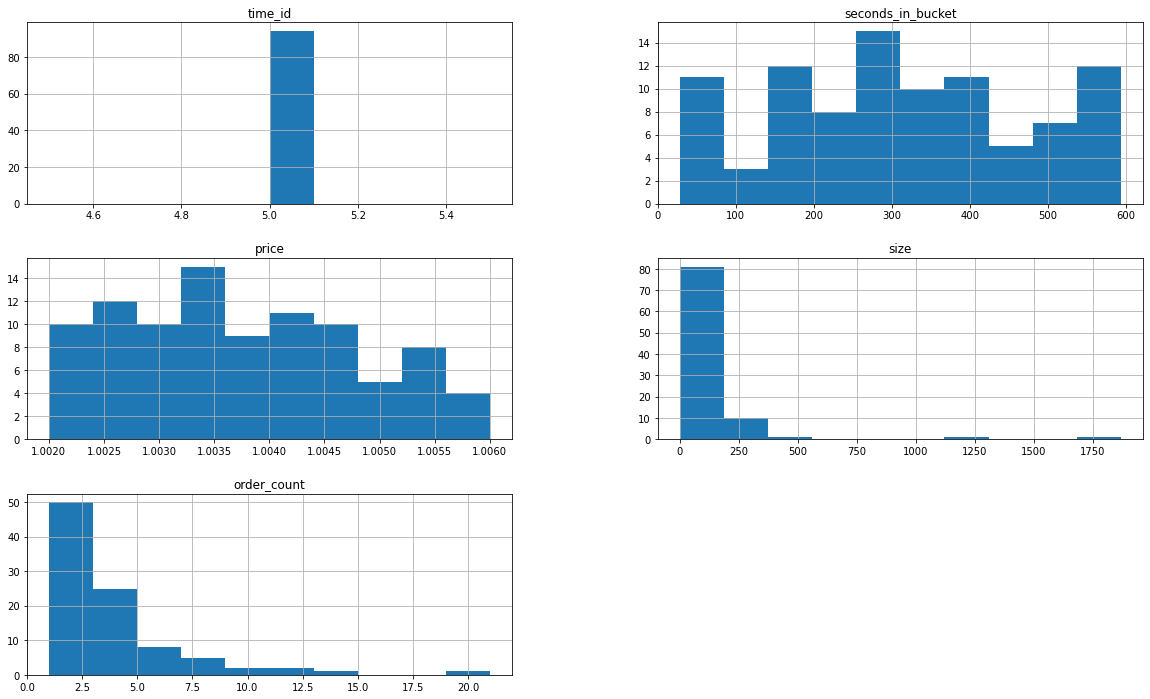

In [40]:
trade_study.hist(figsize=(20,12))
plt.show()

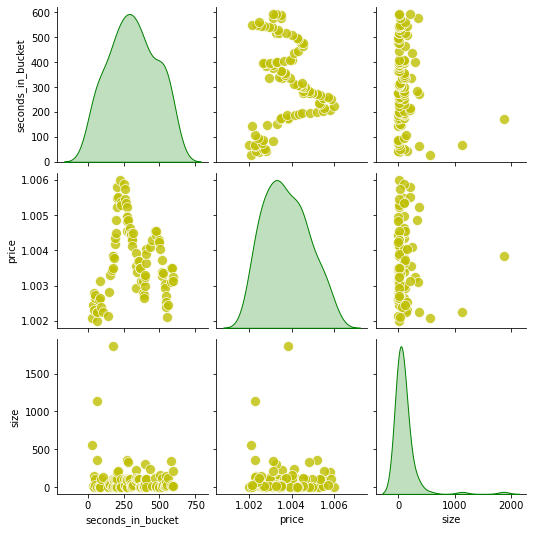

In [41]:
sns.pairplot(
    trade_study[['seconds_in_bucket','price','size']], 
    kind='scatter', 
    diag_kind="kde", 
    diag_kws=dict(shade=True, color='g'),
    plot_kws=dict(s=100, color='y', alpha=0.8),
    height=2.5
)
plt.show()

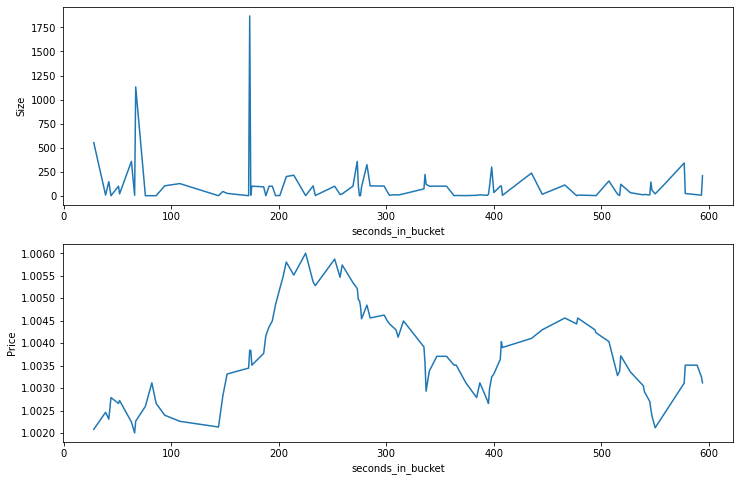

In [42]:
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0] = sns.lineplot(data=trade_study, x="seconds_in_bucket", y="size", ax=ax[0])
ax[0].set_ylabel('Size')
ax[1] = sns.lineplot(data=trade_study, x="seconds_in_bucket", y="price", ax=ax[1])
ax[1].set_ylabel('Price')
plt.show()

**5.3 Comprehensive Chart combines bid/ask price & deal price**

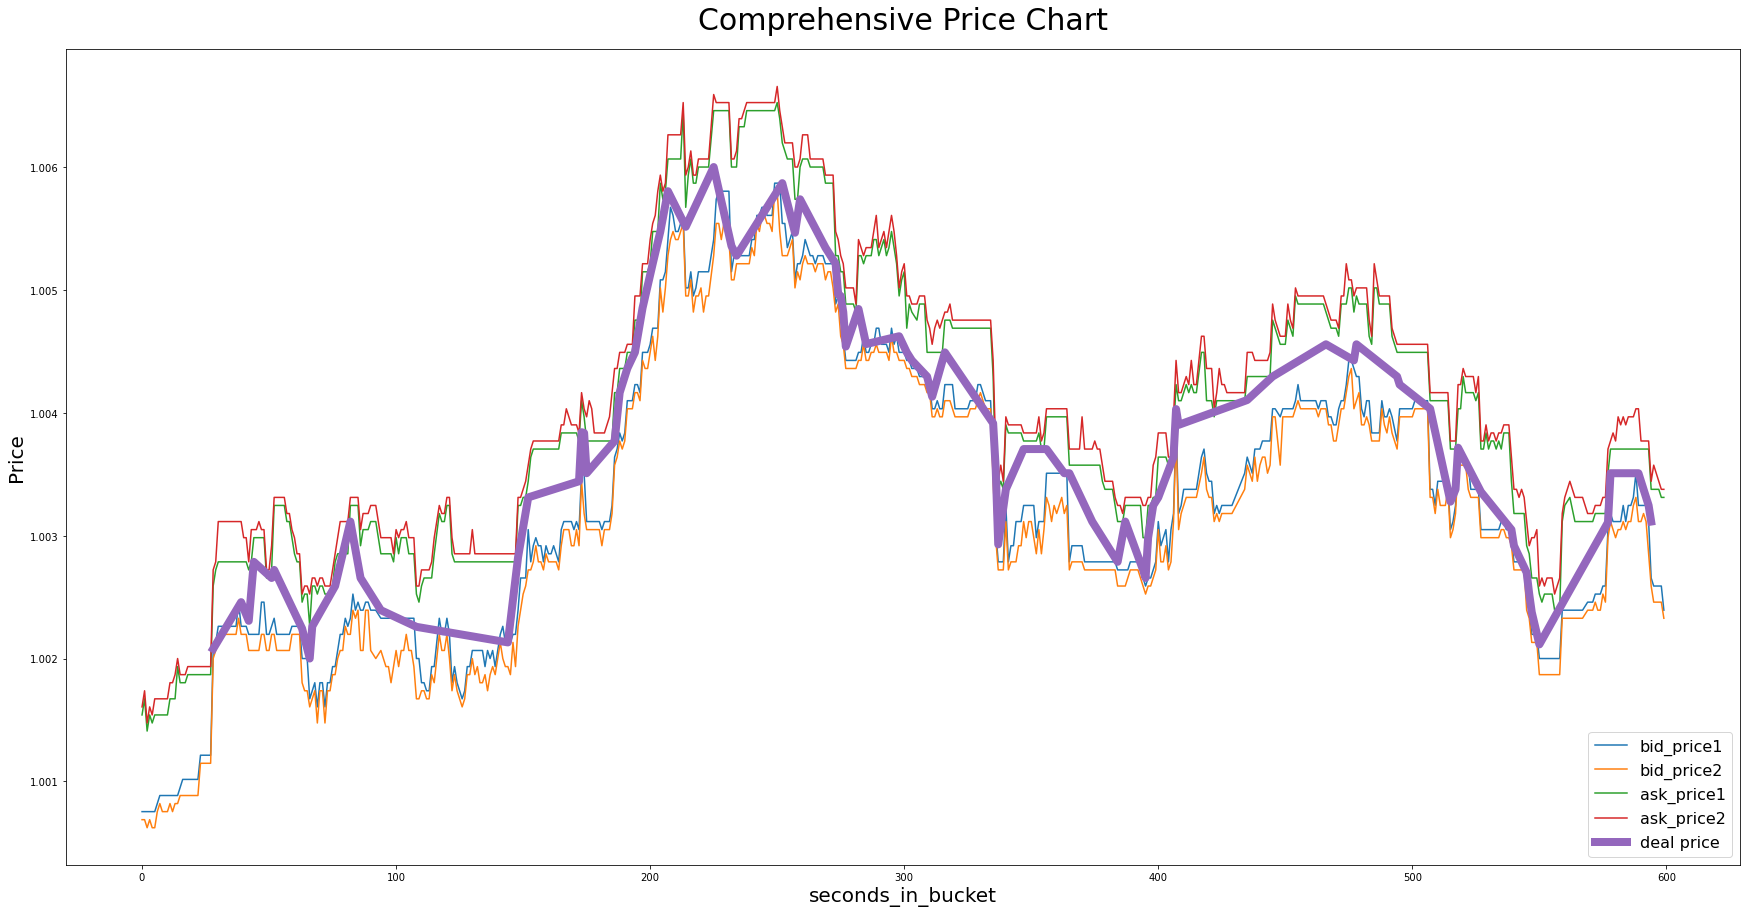

In [49]:
plt.figure(figsize=(30, 15))
for num, name in enumerate(select_price):
    plt.plot(book_study['seconds_in_bucket'], book_study[name], label=name)
plt.plot(trade_study['seconds_in_bucket'], trade_study['price'], label='deal price',lw=8)
plt.legend(loc=4, fontsize=16)
plt.xlabel('seconds_in_bucket', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Comprehensive Price Chart', fontsize=30, pad=20)
plt.show()

The deal price is the price at which the bid price equals to ask price, thus the deal is successdually made.